# BITCOIN MARKET ANALYSIS

PROJECT OVERVIEW: 
Given the complex nature of cryptos and their underlying technology, it is more important for us to engage in research to assess the viability and potential of the coins. This ensures that we make better investment decisions and are kept in the loop of things. But more importantly, a good understanding of a coin’s fundamentals allows us to form our own opinions. In this project we are trying to establish relationship between the bitcoin data to predict its value in the future to make informed decisions.

In [1]:
# LSTM for closing bitcoin price with regression framing

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math

Using TensorFlow backend.


In [3]:
import os

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [5]:
# load the dataset
df = pd.read_csv('crypto.csv', index_col='date', parse_dates=True, low_memory=False)

In [6]:
df.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


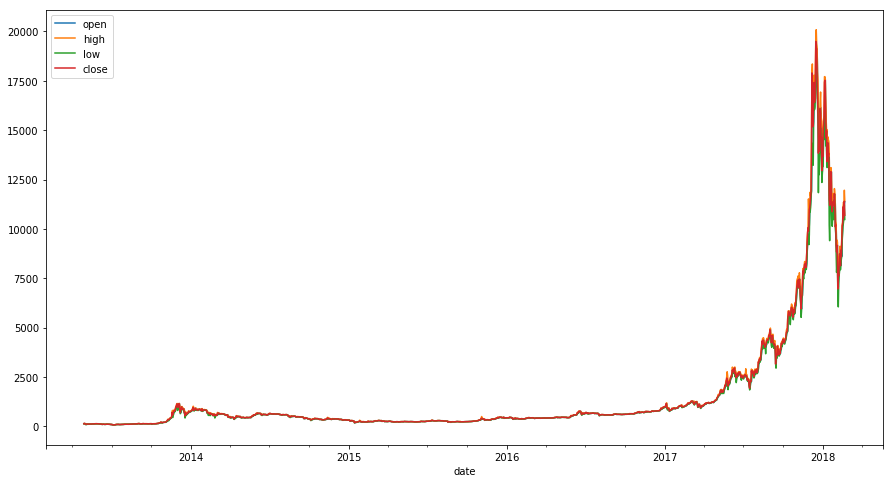

In [7]:
bitcoin_price = df[df['name']=='Bitcoin']
bitcoin_price[['open','high','low','close']].plot(figsize=(15,8))

In [8]:
bitcoin_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2013-04-28 to 2018-02-21
Data columns (total 12 columns):
slug           1761 non-null object
symbol         1761 non-null object
name           1761 non-null object
ranknow        1761 non-null int64
open           1761 non-null float64
high           1761 non-null float64
low            1761 non-null float64
close          1761 non-null float64
volume         1761 non-null int64
market         1761 non-null int64
close_ratio    1761 non-null float64
spread         1761 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 178.9+ KB


# QUESTION: Why do we predict the price of Bitcoins? 

<b>MARKET CAP</b> <br> 
Market cap, also known as market capitalization is the total market value of all of a company's outstanding shares

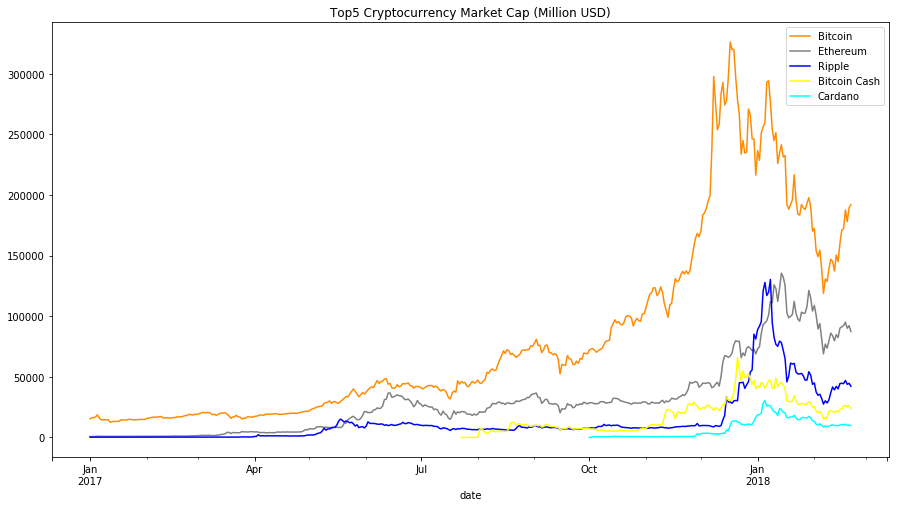

In [9]:
bitcoin = df[df['name']=='Bitcoin'].loc['2017':]
ethereum = df[df['name']=='Ethereum'].loc['2017':]
ripple = df[df['name']=='Ripple'].loc['2017':]
bitcoin_cash = df[df['name']=='Bitcoin Cash'].loc['2017':]
cardano = df[df['name']=='Cardano'].loc['2017':]

plt.figure(figsize=(15,8))
(bitcoin['market']/1000000).plot(color='darkorange', label='Bitcoin')
(ethereum['market']/1000000).plot(color='grey', label='Ethereum')
(ripple['market']/1000000).plot(color='blue', label='Ripple')
(bitcoin_cash['market']/1000000).plot(color='yellow', label='Bitcoin Cash')
(cardano['market']/1000000).plot(color='cyan', label='Cardano')
plt.legend()
plt.title('Top5 Cryptocurrency Market Cap (Million USD)')
plt.show()

<b>Trade Volume</b><br>
let's see the trading volume of the current top 5 cryptocurrencies from early 2017

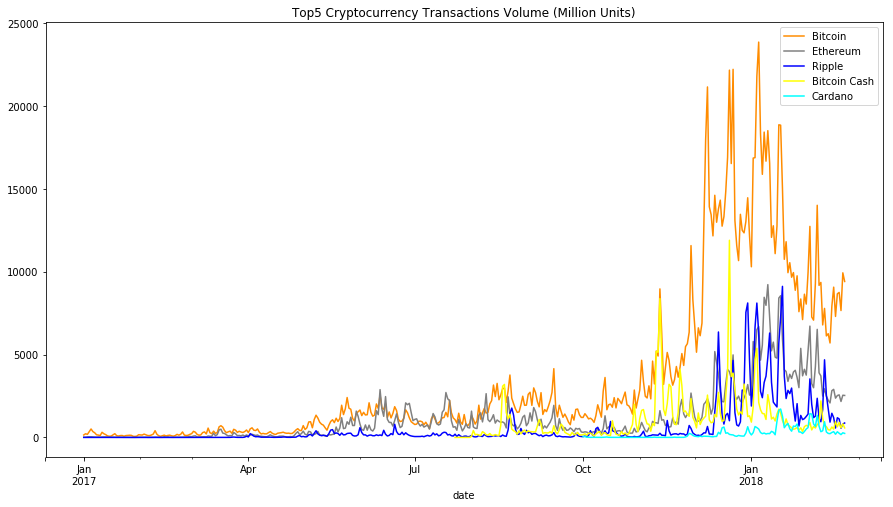

In [10]:
plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(ethereum['volume']/1000000).plot(color='grey', label='Ethereum')
(ripple['volume']/1000000).plot(color='blue', label='Ripple')
(bitcoin_cash['volume']/1000000).plot(color='yellow', label='Bitcoin Cash')
(cardano['volume']/1000000).plot(color='cyan', label='Cardano')
plt.legend()
plt.title('Top5 Cryptocurrency Transactions Volume (Million Units)')
plt.show()

In [11]:
# convert an array of values into a dataset matrix

In [12]:
def create_dataset(dataset):
  dataX, dataY = [], []
  for i in range(len(dataset)-1):
    dataX.append(dataset[i])
    dataY.append(dataset[i + 1])
  return np.asarray(dataX), np.asarray(dataY)

In [13]:
# fix random seed for reproducibility

In [14]:
np.random.seed(7)

In [15]:
bitcoin_price = bitcoin_price.iloc[::-1]
df = bitcoin_price.drop(['ranknow','symbol','slug','name','open','high','low','volume','market','close_ratio','spread'], axis=1)
dataset = df.values
dataset = dataset.astype('float32')


In [16]:
dataset

array([[ 10690.40039062],
       [ 11403.70019531],
       [ 11225.29980469],
       ..., 
       [   139.        ],
       [   144.53999329],
       [   134.21000671]], dtype=float32)

LSTMs are sensitive to the scale of the input data. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library

In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

The function takes one argument: the dataset, which is a NumPy array that we want to convert into a dataset. This function will create a dataset where X is the closing price of Bitcoin at a given time (t) and Y is the closing price of Bitcoin at the next time (t+1).

In [18]:
#prepare the X and Y label

In [19]:
X,y = create_dataset(dataset)

In [20]:
#Take 80% of data as the training sample and 20% as testing sample

In [21]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20)

The shape of the input data (X) for the LSTM network should be specifically in the form of [samples, time steps, features].<br>
Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using np.reshape() as follows:

In [22]:
# reshape input to be [samples, time steps, features]

In [23]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design the LSTM model for our problem. The network has 1 input layer, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The LSTM blocks use sigmoid activation function by default. We train the network for 5 epochs and use a batch size of 1. Once trained, you can save the model using the model.save method. You can also use the load_model method to load a pre-trained model.

In [24]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 13s - loss: 0.0062
Epoch 2/5
 - 14s - loss: 2.3746e-04
Epoch 3/5
 - 14s - loss: 2.6580e-04
Epoch 4/5
 - 13s - loss: 2.8385e-04
Epoch 5/5
 - 13s - loss: 2.4526e-04


# What is our prediction?

We can estimate the performance of the model on the test dataset once the model is fit.


In [26]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We are inverting the predictions before calculating error scores to ensure that performance is reported in the same units as the original data.

In [27]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [28]:
MSE = ((testPredict - testY) ** 2).mean(axis=None)
rmse = MSE**0.5
print('Root Mean Squared Error',rmse)

Root Mean Squared Error 164.337305564


For predicting Cryptocurrency price for tomorrow. We can use our model,pass today’s price as the input parameter. 

In [29]:
print("Price for last 5 days: ")
print(testPredict[-5:])
futurePredict = model.predict(np.asarray([[testPredict[-1]]]))
futurePredict = scaler.inverse_transform(futurePredict)
print("Bitcoin price for tomorrow: ", futurePredict)

Price for last 5 days: 
[[ 7562.05273438]
 [  191.41098022]
 [  748.14025879]
 [  459.30316162]
 [  163.67649841]]
Bitcoin price for tomorrow:  [[ 191093.25]]


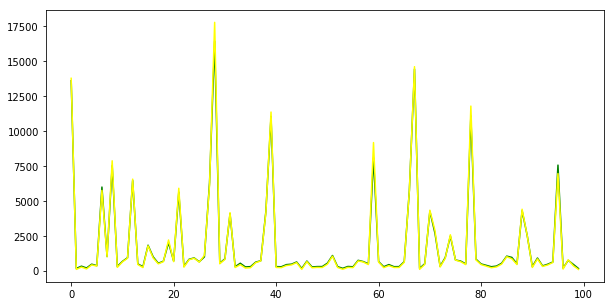

In [30]:
plt.figure(figsize=(10,5))
plt.plot(testPredict[-100:] ,color='green',label='Predicted data')
plt.plot(testY[-100:],color='yellow',label='test data')
plt.show()

# CONCLUSION

By building a robust predictive model, we can predict the behavior of bitcoins each month and in future, understand their trends and make healthy investment plans in future.